# Evaluating Perception with respect to System-level Specifications
### Simulating saved results
This Jupyter notebook describes the case study for deriving specifications for the perception module from system-level specifications and specifications for the control module. This notebook introduces the theory behind the case study and reruns results from saved data. Instructions for running this example from scratch are will be released shortly.

## Motivation
Temporal logic has been an effective formalism for specifying system-level requirements that correspond to safe operation of autonomous vehicles ([Baier & Katoen](#ref0), [Piterman et al.](#ref1)). Formally specifying these requirements in temporal logic has led to an effective paradigm for synthesizing correct controllers at a high-level of abstraction (as seen in [Wongpiromsarn et al. 2012](#ref2), [Kress-Gazit et al. 2009](#ref3),[Lahijanian et al. 2009](#ref4), [Kloetzer et al. 2008](#ref6)). However, most of these control synthesis techniques assume perfect perception and do not account for perception errors. Consider the object detection task of the perception component---it is not possible to train a neural network that correctly detects every object due to the well-known precision-recall tradeoff (see [Geron 2019](#ref7), [Koyejo et al. 2015](#ref5), [Wang et al. 2019](#ref12), [Narasimhan et al. 2015](#ref10)). Thus, the correctness guarantees of the synthesized controller, which are predicated on the correctness of object detection, will not always hold. 

In [BWM 21](#ref8), the authors presented the of use of the confusion matrix, a popular metric for evaluating object detection performance in the computer vision community, to quantitatively evaluate the end-to-end detection and planning stack with respect to system-level temporal logic requirements. 

To reduce conservativeness in this probabilistic analysis, the canonical confusion matrix was adapted to formally define new evaluation metrics for object detection by accounting for the structure of the downstream controller [BWM 22](#ref9).

Since the confusion matrix can be seen as an evaluation metric for object detection, characterizing the elements of the confusion matrix (such as true positive rates for each class) can be a way to formally specify requirements on the object detection module.

In [23]:
# Import libraries
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from PIL import Image

from pacti.terms.polyhedra import PolyhedralContract


## Part 1: Example

In this case study, we illustrate constructing lower bounds for elements of the confusion matrix. Consider the car pedestrian example examined in this case study. For the purposes of this jupyter notebook, the pedestrian is located 4 cells away from the car, which is starting at cell $C_1$ with an initial speed of 1 cell/step and a maximum possible speed of 2 cells/step.

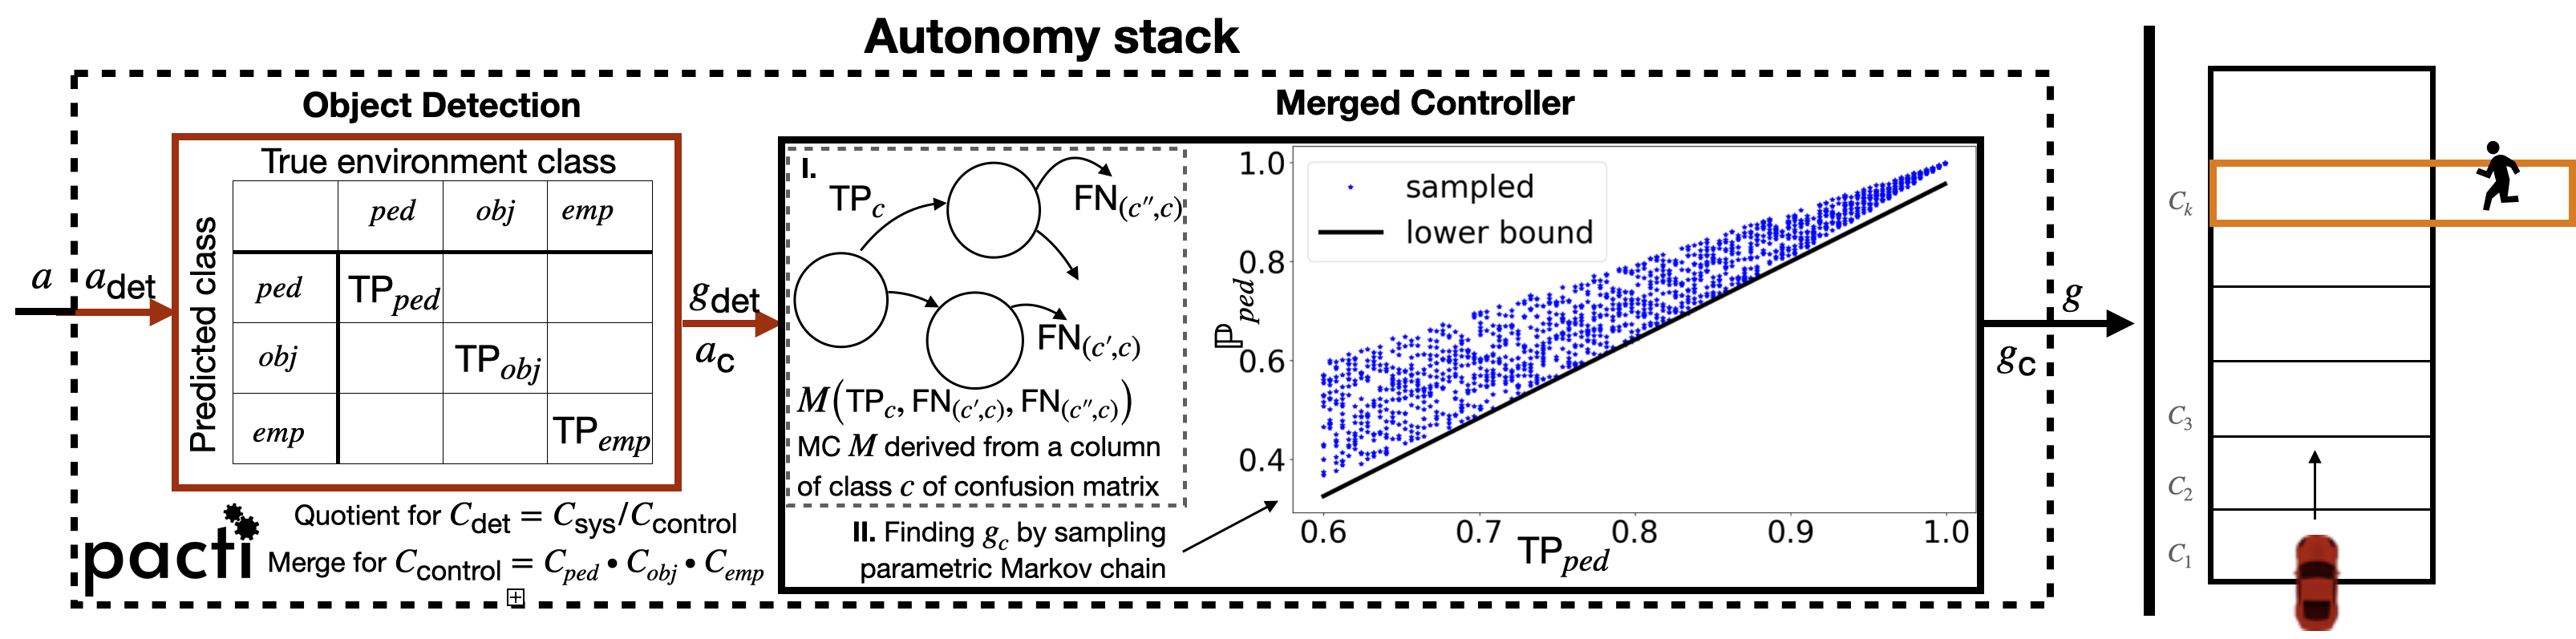

In [7]:
Image("imglib/autonomy-stack.png")

## Part 2: Getting probability points for ped, obj, empty:

Now, we illustrate the construction of controller contracts for the specific car pedestrain example given above. Suppose $c$ is the object class of the true environment. Since the probability of satisfaction of formula $\varphi_c$ is a nonlinear function of the elements of the confusion matrix, we compute an affine lower bound of this function via sampling. For each true positive rate, $\mathtt{TP}_{c}$, for a environment object type $c$, we generate 15 random instantiations of the false negative rates, $\mathtt{FN}_{(c',c)}$ and $\mathtt{FN}_{(c'',c)}$, where $c \notin \{c',c''\}$. For each instantiation of the confusion matrix, we construct the corresponding Markov chain $M(\mathtt{TP}_{c}, \mathtt{FN}_{(c',c)}, \mathtt{FN}_{(c'',c)})$ and compute the satisfaction probability accordingly. For all the probability samples, we then use linear programming to compute a lower bound as a function of the true positive rate.

In [8]:
# Here we load probability points from saved pickle files. To fully recompute the results, see recompute.ipynb

with open("lb.pkl", "rb") as f:
    lbounds_ped, points_ped, tpped_vals = pkl.load(f)
f.close()

with open("lbobj.pkl", "rb") as f:
    lbounds_obj, points_obj, tpobj_vals = pkl.load(f)
f.close()

with open("lbempty.pkl", "rb") as f:
    lbounds_emp, points_emp, tpemp_vals = pkl.load(f)
f.close()

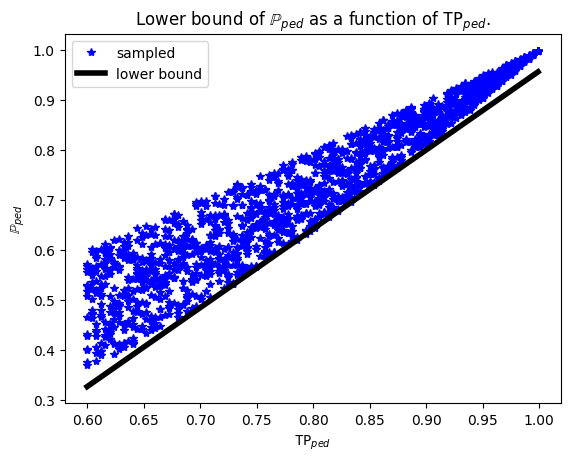

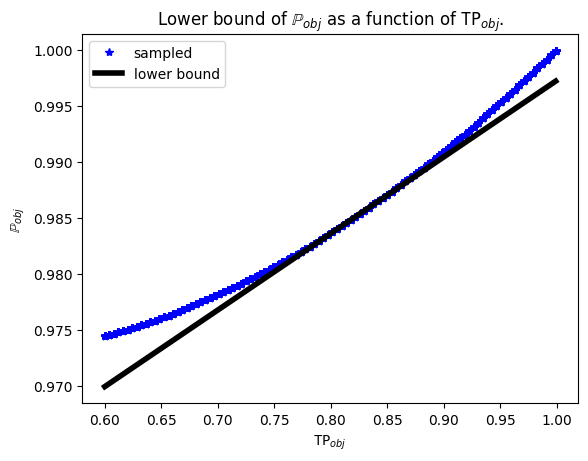

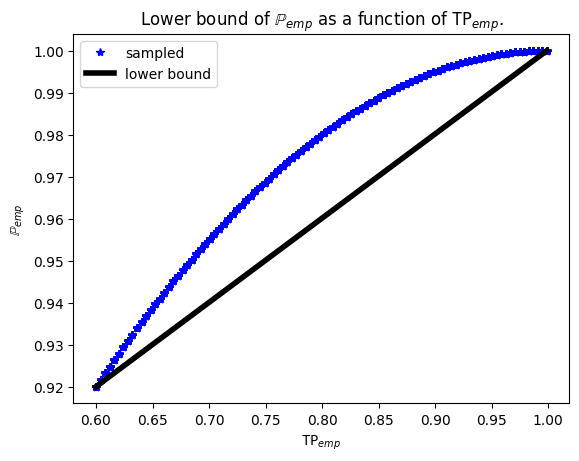

In [9]:
# Plotting Probabilities:
def plot_probabilities_bounds(points, tp_vals, ubounds, lbounds, true_env):
    fig, ax = plt.subplots()
    ax.tick_params(axis="both", which="major", labelsize=10)
    plt.plot(tp_vals, points, "b*", label="sampled")
    if ubounds != []:
        ub_m, ub_c = ubounds
        y_ub = ub_m * np.array(tp_vals) + ub_c
        plt.plot(tp_vals, y_ub, "r")

    lb_m, lb_c = lbounds
    y_lb = lb_m * np.array(tp_vals) + lb_c
    plt.plot(tp_vals, y_lb, "k", label="lower bound", linewidth=4)
    lb = min(tp_vals)
    ub = max(tp_vals)
    plt.legend(prop={"size": 10})

    plt.title("Lower bound of $\mathbb{P}_{" + true_env + "}$ as a function of $\mathtt{TP}_{" + true_env + "}$.")
    plt.ylabel("$\mathbb{P}_{" + true_env + "}$")
    plt.xlabel("$\mathtt{TP}_{" + true_env + "}$")


plot_probabilities_bounds(points_ped, tpped_vals, [], lbounds_ped, "ped")
plot_probabilities_bounds(points_obj, tpobj_vals, [], lbounds_obj, "obj")
plot_probabilities_bounds(points_emp, tpemp_vals, [], lbounds_emp, "emp")

## Part 3: Controller Contracts

In [24]:
# First we construct each contract individually, and then merge the controller contract:
## Control contract for pedestrian class
def control_contract_ped(lbounds_ped):
    lb_m, lb_c = lbounds_ped
    tp = "tp_ped"
    P = "P_ped"
    input_vars = [tp]
    output_vars = [P]
    assumptions = [f"{tp} <= 1", f"-{tp} <= -0.6"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cped = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cped


def control_contract_obj(lbounds_obj):
    lb_m, lb_c = lbounds_obj

    tp = "tp_obj"
    P = "P_obj"
    input_vars = [tp]
    output_vars = [P]
    assumptions = [f"{tp} <= 1", f"-{tp} <= -0.3"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cobj = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cobj


def control_contract_emp(lbounds_emp):
    lb_m, lb_c = lbounds_emp

    tp = "tp_emp"
    P = "P_emp"
    input_vars = [tp]
    output_vars = [P]
    assumptions = [f"{tp} <= 1", f"-{tp} <= -0.6"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cemp = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cemp


Cped = control_contract_ped(lbounds_ped)
Cobj = control_contract_obj(lbounds_obj)
Cemp = control_contract_emp(lbounds_emp)

print("Controller Contract for pedestrian class:\n" + str(Cped) + "\n")
print("Controller Contract for object class:\n" + str(Cobj) + "\n")
print("Controller Contract for empty class:\n" + str(Cemp) + "\n")

Controller Contract for pedestrian class:
InVars: [tp_ped]
OutVars:[P_ped]
A: [
  tp_ped <= 1.0
  -tp_ped <= -0.6
]
G: [
  -P_ped + 1.5801256015029996 tp_ped <= 0.6220524909016469
]

Controller Contract for object class:
InVars: [tp_obj]
OutVars:[P_obj]
A: [
  tp_obj <= 1.0
  -tp_obj <= -0.3
]
G: [
  -P_obj + 0.06834814849496082 tp_obj <= -0.9288940771532732
]

Controller Contract for empty class:
InVars: [tp_emp]
OutVars:[P_emp]
A: [
  tp_emp <= 1.0
  -tp_emp <= -0.6
]
G: [
  -P_emp + 0.20049999999999998 tp_emp <= -0.7996999999999667
]



In [25]:
# Construct merger of contracts:
C_controller = Cped.merge(Cobj)
C_controller = C_controller.merge(Cemp)

print("Merged Controller Contract for all object classes:\n" + str(C_controller) + "\n")

IncompatibleArgsError: Asked to merge incompatible contracts

In [22]:
## System contract: P >= 0.99
def system_contract_dist():
    a1, a2, a3 = 0.99, 0.8, 0.95
    d = "d"
    P_emp = "P_emp"
    P_obj = "P_obj"
    P_ped = "P_ped"
    input_vars = [d]
    output_vars = [P_ped, P_obj, P_emp]
    assumptions = [
        f"-{d} <= 0",
        f"{d} <= 10",
        ]
    guarantees = [
        f"-{P_ped} + "+str(0.1*a1)+ f"{d} <= "+str(-1*a1),
        f"-{P_obj} + "+str(0.1*a2)+ f"{d} <= "+str(-1*a2),
        f"-{P_emp} + "+str(0.1*a3)+ f"{d} <= "+str(-1*a3),
        ]
    system_contract = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return system_contract

Csys_dist = system_contract_dist()
print("System Contract (distance bounds):\n" + str(Csys_dist) + "\n")

System Contract (distance bounds):
InVars: [d]
OutVars:[P_ped, P_obj, P_emp]
A: [
  -d <= 0.0
  d <= 10.0
]
G: [
  -P_ped + 0.099 d <= -0.99
  -P_obj + 0.08000000000000002 d <= -0.8
  -P_emp + 0.095 d <= -0.95
]



In [42]:
# Computing quotient contract:
C_dist = Csys_dist.quotient(C_controller)
print("Quotient Contract with distance bounds on true positive rates:\n" + str(C_dist) + "\n")

Quotient Contract with distance bounds on true positive rates:
InVars: [d]
OutVars:[tp_ped, tp_obj, tp_emp]
A: [
  -d <= 0.0
  d <= 10.0
]
G: [
  -0.099 d - 1.580125601503 tp_ped <= -1.6120524909016472
  tp_ped <= 1.0
  -tp_ped <= -0.6
  tp_obj <= 1.0
  -tp_obj <= -0.30000000000000004
  tp_emp <= 1.0
  -tp_emp <= -0.6
]



## References

<a id="ref0"></a> __[Baier and Katoen. 2008](http://perso.ens-lyon.fr/quentin.guilmant/M1/Semestre2/SV/_principles_of_model_checking.pdf)__

Baier, Christel, and Joost-Pieter Katoen. 
**Principles of Model Checking.**

<a id="ref1"></a> __[Piterman et al. 2006](http://jtlv.ysaar.net/resources/publications/synth.pdf)__

Piterman, N., Pnueli, A., Sa’ar, Y.
**Synthesis of reactive (1) designs.**
In: International Workshop on Verification, Model Checking, and Abstract Interpretation.
pp. 364–380. Springer (2006)

<a id="ref2"></a> __[Wongpiromsarn et al. 2012](https://authors.library.caltech.edu/36081/)__

Wongpiromsarn, T., Topcu, U., Murray, R.M.
**Receding horizon temporal logic planning**
IEEE Transactions on Automatic Control 57(11), 2817–2830 (2012)

<a id="ref3"></a> __[Kress-Gazit et al. 2009](https://georgejpappas.org/papers/IEEE-LTL2009.pdf)__

Kress-Gazit, H., Fainekos, G.E., Pappas, G.J.: 
**Temporal-logic-based reactive mission and motion planning.**
IEEE Transactions on Robotics 25(6), 1370–1381 (2009) 26. 

<a id="ref4"></a> __[Lahijanian et al. 2009](https://www.bu.edu/anderssonlab/files/2013/08/IEEE_Conference_on_Decision_and_Control_2009_Lahijanian.pdf)__

Lahijanian, M., Andersson, S.B., Belta, C.
**A probabilistic approach for control of a stochastic system from LTL specifications.**
In: Proceedings of the 48h IEEE Conference on Decision and Control (CDC) held jointly with 2009 28th Chinese
Control Conference. pp. 2236–2241. IEEE (2009)

<a id="ref5"></a> __[Koyejo et al. 2015](https://proceedings.neurips.cc/paper/2015/file/85f007f8c50dd25f5a45fca73cad64bd-Paper.pdf)__

Koyejo, O., Natarajan, N., Ravikumar, P., Dhillon, I.S.
**Consistent multilabel classification.**
In: NeurIPS. vol. 29, pp. 3321–3329 (2015)


<a id="ref6"></a> __[Kloetzer et al. 2008](https://sites.bu.edu/hyness/files/2014/05/TAC08_LTL_Contr.pdf)__

Kloetzer, M., Belta, C.
**A fully automated framework for control of linear systems from temporal logic specifications.**
IEEE Transactions on Automatic Control 53(1),
287–297 (2008)

<a id="ref7"></a> __[Geron et al. 2019](https://github.com/ageron/handson-ml2)__

Géron, A.: Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow:
Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media
(2019)

<a id="ref8"></a> __[BWM 2021](https://ieeexplore.ieee.org/document/9683611)__

Badithela, A., Wongpiromsarn, T., Murray, R.M.: Leveraging classification metrics
for quantitative system-level analysis with temporal logic specifications. In: 2021
60th IEEE Conference on Decision and Control (CDC). pp. 564–571. IEEE (2021)


<a id="ref9"></a> __[BWM 2022](https://arxiv.org/pdf/2210.10298)__

Badithela, A., Wongpiromsarn, T., Murray, R.M.: Evaluation metrics for object
detection for autonomous systems. arXiv preprint arXiv:2210.10298 (2022)

<a id="ref10"></a> __[Narasimhan et al. 2015](http://proceedings.mlr.press/v37/narasimhanb15.pdf)__
Narasimhan, H., Ramaswamy, H., Saha, A., Agarwal, S.

**Consistent multiclass algorithms for complex performance measures.**
In: International Conference on
Machine Learning. pp. 2398–2407. PMLR (2015)

<a id="ref11"></a> __[Topan et al. 2022](https://arxiv.org/abs/2206.12471)__

Topan, S., Leung, K., Chen, Y., Tupekar, P., Schmerling, E., Nilsson, J., Cox, M.,
Pavone, M.

**Interaction-dynamics-aware perception zones for obstacle detection safety evaluation.**

In: 2022 IEEE Intelligent Vehicles Symposium (IV). pp. 1201–1210. IEEE (2022)

<a id="ref12"></a> __[Wang et al. 2019](https://arxiv.org/pdf/1908.09057)__

Wang, X., Li, R., Yan, B., Koyejo, O.
**Consistent classification with generalized metrics.**
arXiv preprint arXiv:1908.09057 (2019)
